In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.distributions as D
import matplotlib

import sys
sys.path.extend(['..'])

from mutual_information import NCE_MI_approx as MI_approx

In [3]:
from tqdm import tqdm

# Sampling kernels using the NCE estimator

As shown by [Poole et al. 2019](http://proceedings.mlr.press/v97/poole19a/poole19a.pdf), a useful lower bound for the mutual information between $\Psi(\theta)$ and $m(x)$ can be obtained if $q(x|\theta)$ is of known form. It follows from the Noise-Constrastive Estimation family – but contains no learnable parameters. It is defined in expectation over $K$ samples from the joint distribution $\Psi(\theta)q(x|\theta)$:
$$
I(x;\theta)\geq \mathbb{E}\bigg[\frac1K\sum^K_{i=1}\log\frac{q(x_i|\theta_i)}{\frac1K\sum^K_{j=1}q(x_i|\theta_j)}\bigg]
$$ 
## Optimizing an ensemble of $\theta$ points.

Our approach with this estimator is to define an *energy* over an ensemble of points standing in for $\Psi$:
$$
    L(\Psi,\lambda) = MI[x;\theta] - \lambda \left(\int_\theta \Psi(\theta) KL(q(x;\theta)||p^*(x)) \theta - C\right)
$$

This can be minimized.

We can additionally add some noise to the sampler. This implicity produces samples from (approximately) $\Psi$ but with added entropy corresponding to the noise.

In [40]:

class LangevinContrastiveSampler1d(object):
    """This holds n_chains and runs them in parallel. 
    
    Inputs:
    n_chains: K kernels (int)
    lambda_: lambda (float)
    target: A distribution. Must have a .log_prob(sample) method that takes and gives Tensors on
                the same device as samples.device
    lr: gradient descent learning rate
    """
    def __init__(self, n_chains, lambda_, target, lr=0.01, device='cpu'):
        # current parameter set
        self.curr_params = torch.randn(n_chains, 2, device=device, requires_grad=True)
        self.curr_params.data[:,1] -= 1
        # for logging
        self.unique_param_history = [self.curr_params.detach().cpu()] # stored on cpu for mem
        self.energy_history=[]
        
        self.lambda_ = lambda_
        self.target = target
        self.optimizer = torch.optim.SGD([self.curr_params], lr=lr, momentum=0.5)
        self.device=device
        self.n_chains=n_chains
        
    def step(self, var=1, mc_n=1):
        """Takes a step following the gradient of the energy. 
        Optionally:
        var (float): Adds noise with var to the current parameters
        mc_n (int>0): Be more accurate with compute! The KL term is computed with a MC procedure by sampling from the qs
                        multiple times each, potentially. we can also compute the NCE MI for each sample draw
                        The final value is the average of these.
        """
        self.optimizer.zero_grad()
        energy = self.energy(self.curr_params,mc_n)
        energy.backward()
        self.curr_params.data += var*torch.randn(self.n_chains, 2, device=self.device)
        self.optimizer.step()
        self.unique_param_history.append(self.curr_params.detach().cpu())
        self.energy_history.append(energy.detach().cpu())
        
    def energy(self, proposals, mc_n=1, marginal_MI=False):
        """MC estimation of KL(q||p*). Calls contrastive estimator of MI.
        ****This is univariate. Would require a refactor if x is >1D.****
                
        mc_n (int>0): Be more accurate with compute! The KL term is computed with a MC procedure by sampling from the qs
                        multiple times each, potentially. we can also compute the NCE MI for each sample draw
                        The final value is the average of these."""
        qs = D.Normal(proposals[:,0],proposals[:,1].exp())
        samples = qs.rsample([mc_n])
        kl = - qs.entropy() - self.target.log_prob(samples).mean(0)
        mi = torch.stack([MI_approx(qs, samples[i], marginal_MI)
                          for i in range(mc_n)]).mean()
        energy = kl.mean()*self.lambda_ - mi
        return energy


## Make a target distribution

Text(0.5, 1.0, 'Target')

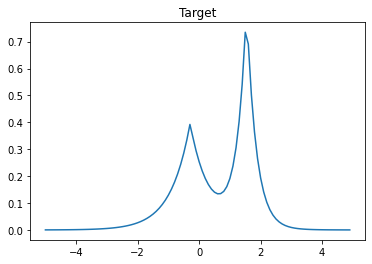

In [42]:
torch.manual_seed(0)
device='cpu'
mix = D.Categorical(torch.ones(2,).to(device))
comp = D.Laplace(torch.randn(2,).to(device), torch.rand(2,).to(device))
target = D.MixtureSameFamily(mix, comp)

# sampler = LangevinContrastiveSampler1d(50,2, target, device=device)
# sampler.step(mc_n=2)
x = torch.arange(-5,5,.1)
y = target.log_prob(x).exp().cpu()
plt.plot(x, y)
plt.title("Target")

In [ ]:
## optimize an ensemble

E: -0.011 lr 0.050: 100%|██████████| 1000/1000 [00:20<00:00, 47.74it/s]


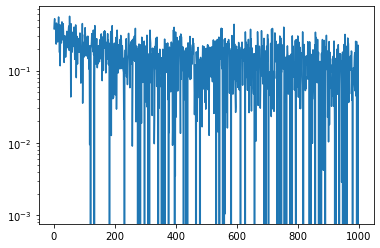

In [43]:
K=100

device='cuda:3'
torch.manual_seed(0)
mix = D.Categorical(torch.ones(2,).to(device))
comp = D.Laplace(torch.randn(2,).to(device), torch.rand(2,).to(device))
target = D.MixtureSameFamily(mix, comp)

sampler = LangevinContrastiveSampler1d(K,1, target, device=device ,lr=.5)
# print(sampler.curr_params[:5])
iterer = tqdm(range(1000))
for _ in iterer:
    sampler.step(var=0.01, mc_n=1)
    sampler.optimizer.param_groups[0]['lr']= .99 * sampler.optimizer.param_groups[0]['lr'] + 0.0005
    iterer.set_description("E: {:.3f} lr {:.3f}".format(sampler.energy_history[-1], 
                                               sampler.optimizer.param_groups[0]['lr']))
plt.semilogy(sampler.energy_history)

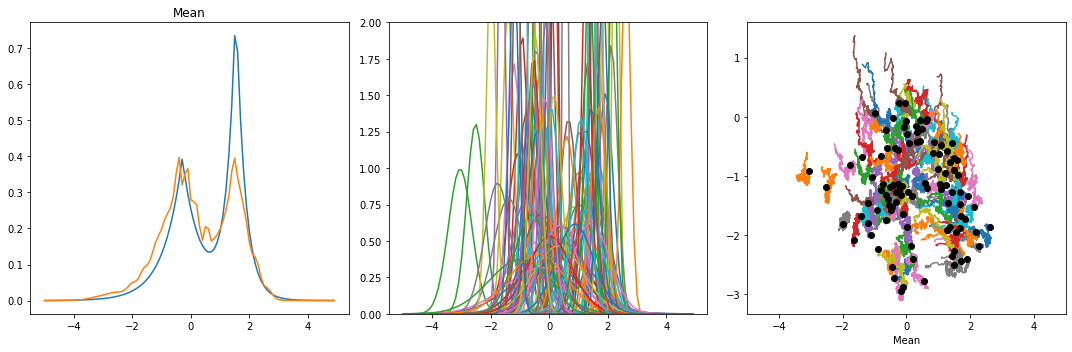

In [45]:
def plot_sampler(sampler):
    plt.figure(figsize=(15,5))
    plt.subplot(131)
    x = torch.arange(-5,5,.1)
    y = sampler.target.log_prob(x.to('cuda:3')).exp().cpu()
    plt.plot(x, y)
    s = sampler.unique_param_history[-1]
    plt.plot(x, torch.stack([D.Normal(s[j,0],
                                      s[j,1].exp()).log_prob(x).exp()
                             for j in range(s.size(0))]).mean(0))
    plt.title("Mean")
    plt.subplot(132)
    plt.plot(x, y)
    for j in range(s.size(0)):
        plt.plot(x, D.Normal(s[j][0],
                             s[j][1].exp()).log_prob(x).exp())
    plt.ylim(0,2)
    plt.subplot(133)
    for i in range(n):
        plt.plot(*torch.cat(sampler.unique_param_history)[i::n].T)
    plt.plot(*sampler.unique_param_history[-1].T,'ko')
    plt.xlabel("Mean")
    plt.xlim(-5,5)
    plt.tight_layout()
plot_sampler(sampler)

### See KL vs. MI

In [48]:
def kl_mi(sampler, mc_n=1, history=1, skip=1):
    """MC estimation of KL(q||p*). Calls contrastive estimator of MI.
    This is univariate. Would require a refactor if x is >1D.
    History and skip determine how far back in the sampler history we look."""
    s = torch.cat(sampler.unique_param_history[-history::skip]).to(sampler.device)    
    qs = D.Normal(s[:,0],s[:,1].exp())
    samples = qs.rsample([mc_n])
    kl = - qs.entropy() - sampler.target.log_prob(samples).mean(0)
    mi = torch.stack([MI_approx(qs, samples[i],False)
                      for i in range(mc_n)]).mean()
    return kl.mean(), mi

N=100, Lambda=1.0, E: 0.045 : 100%|██████████| 300/300 [00:06<00:00, 48.14it/s] 


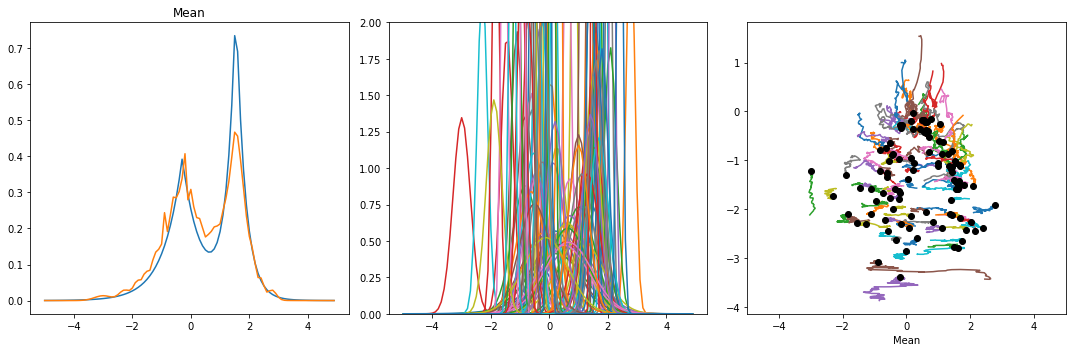

N=100, Lambda=1.2222222222222223, E: 0.190 : 100%|██████████| 300/300 [00:06<00:00, 48.48it/s]


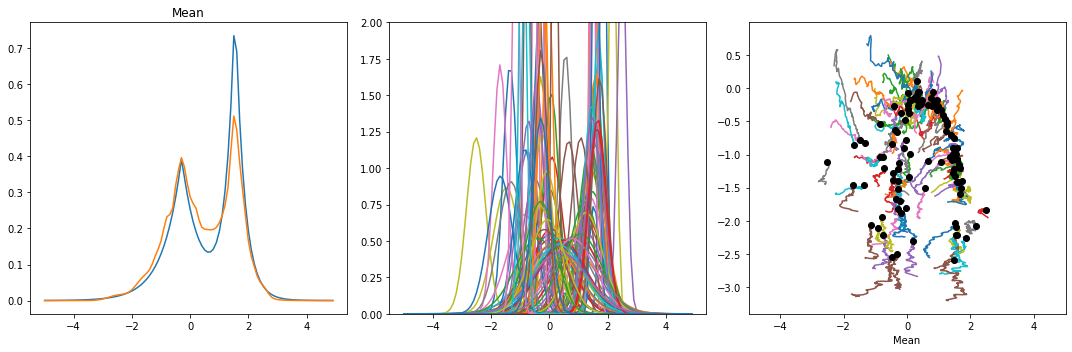

N=100, Lambda=1.4444444444444444, E: 0.469 : 100%|██████████| 300/300 [00:06<00:00, 49.47it/s]


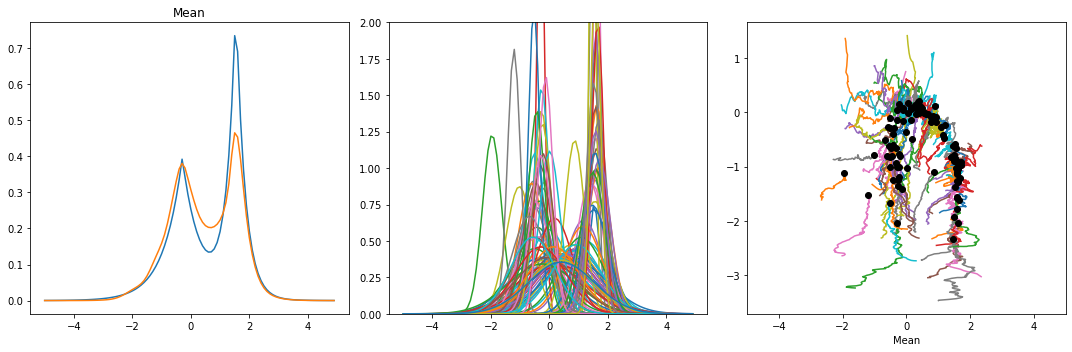

N=100, Lambda=1.6666666666666665, E: 0.606 : 100%|██████████| 300/300 [00:06<00:00, 48.91it/s]


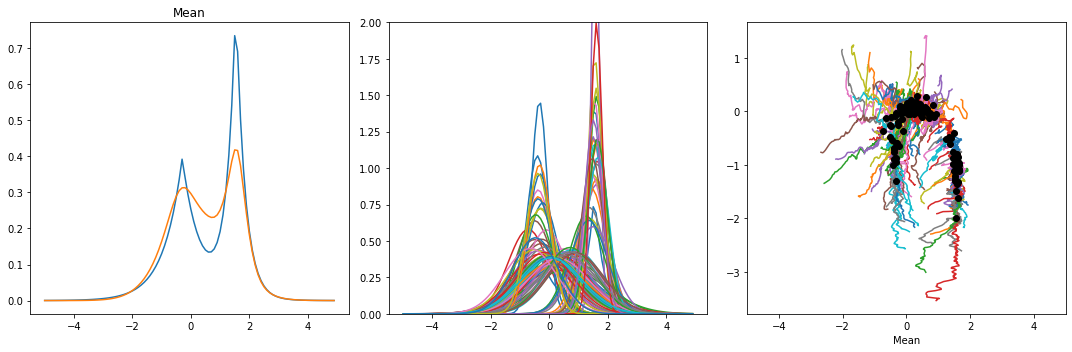

N=100, Lambda=1.8888888888888888, E: 0.533 : 100%|██████████| 300/300 [00:05<00:00, 50.24it/s]


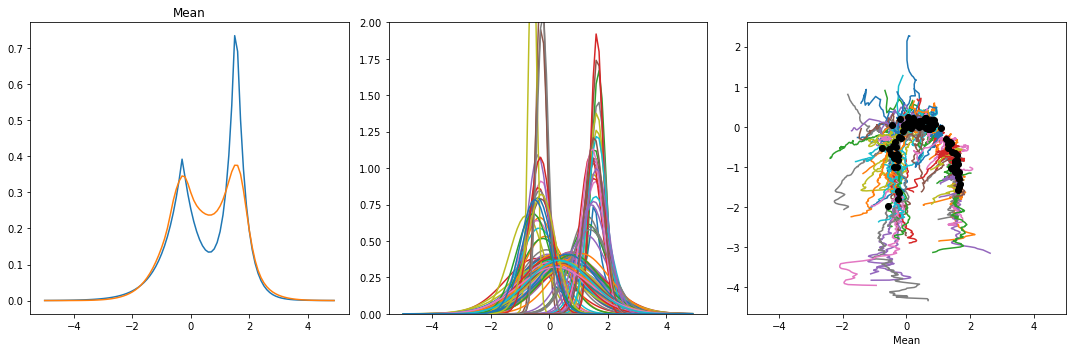

N=100, Lambda=2.111111111111111, E: 0.664 : 100%|██████████| 300/300 [00:06<00:00, 48.85it/s]


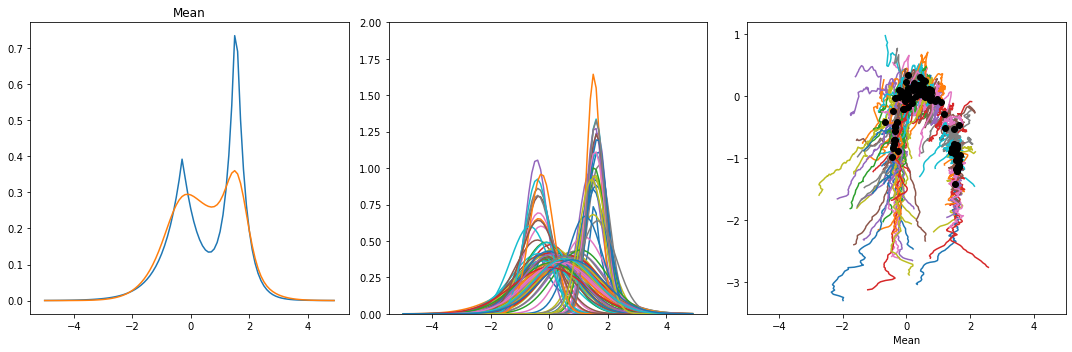

N=100, Lambda=2.333333333333333, E: 0.592 : 100%|██████████| 300/300 [00:06<00:00, 48.79it/s]


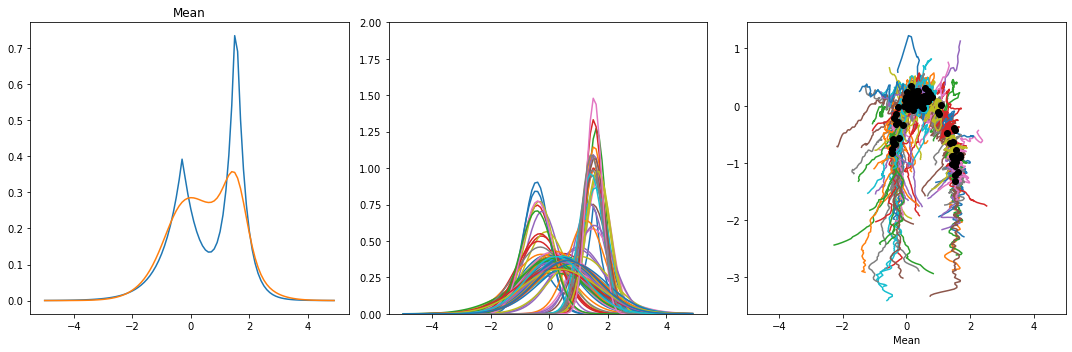

N=100, Lambda=2.5555555555555554, E: 0.669 : 100%|██████████| 300/300 [00:06<00:00, 48.01it/s]


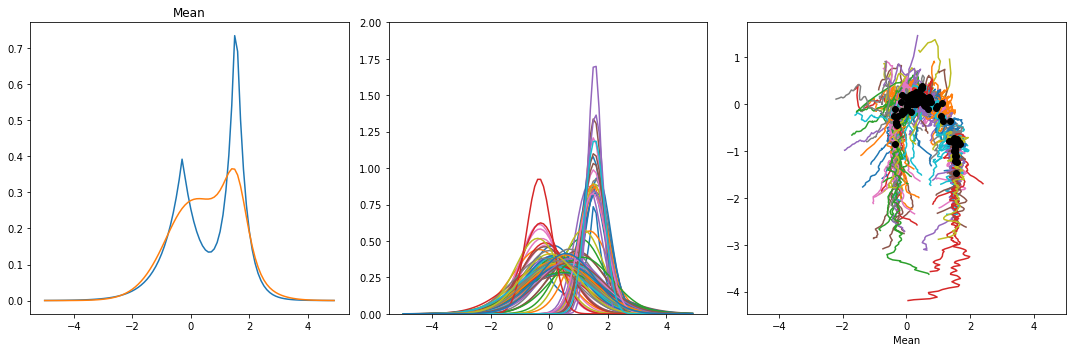

N=100, Lambda=2.7777777777777777, E: 0.770 : 100%|██████████| 300/300 [00:06<00:00, 47.24it/s]


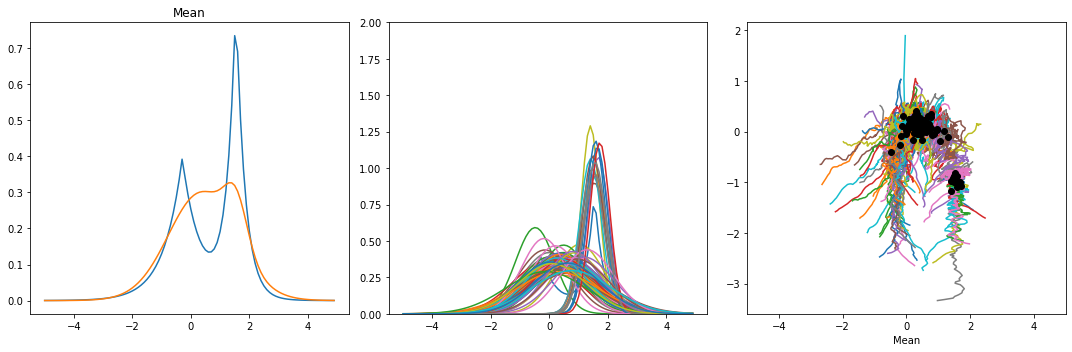

N=100, Lambda=3.0, E: 0.754 : 100%|██████████| 300/300 [00:06<00:00, 49.06it/s]


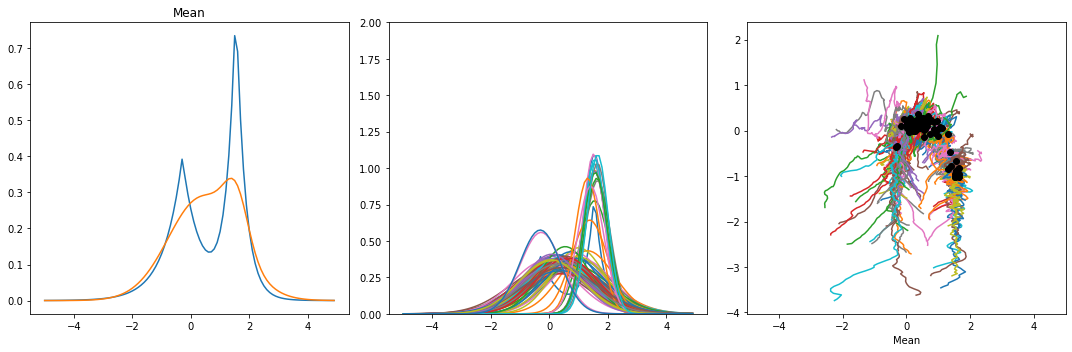

In [50]:
kls=torch.empty(10)
mis=torch.empty(10)
k=100

for j,l in enumerate(np.linspace(1,3,10)):
    try:
        sampler = LangevinContrastiveSampler1d(int(k),l, target,device='cuda:3',lr=1)
        iterer = tqdm(range(300))
        for _ in iterer:
            sampler.step(var=0.001, mc_n=1)
            sampler.optimizer.param_groups[0]['lr']= .99 * sampler.optimizer.param_groups[0]['lr'] + 0.001
            iterer.set_description("N={}, Lambda={}, E: {:.3f} ".format(n,l,sampler.energy_history[-1]))
        kl, mi = kl_mi(sampler,100, history=1, skip=1)
        plot_sampler(sampler);plt.show()
        kls[j]=kl.item()
        mis[j]=mi.item()
        completed=True
    except ValueError:
        print("Skipped")
        continue



In [ ]:
i=9
n=100
for j,l in enumerate(np.linspace(1,3,10)):
    try:
        sampler = LangevinContrastiveSampler(int(n),l, device='cuda:3',lr=1)
        iterer = tqdm(range(1000))
        for _ in iterer:
            sampler.step(var=1e-5, mc_n=10)
            sampler.optimizer.param_groups[0]['lr']= .99 * sampler.optimizer.param_groups[0]['lr'] + 0.001
            iterer.set_description("N={}, Lambda={}, E: {:.3f} ".format(n,l,sampler.energy_history[-1]))
        kl, mi = kl_mi(sampler,100, history=1, skip=1)
        print(kl.item(),mi.item())
        plot_sampler(sampler);plt.show()
        kls[i,j]=kl.item()
        mis[i,j]=mi.item()
        completed=True
    except ValueError:
        print("Skipped")
        continue
            
            

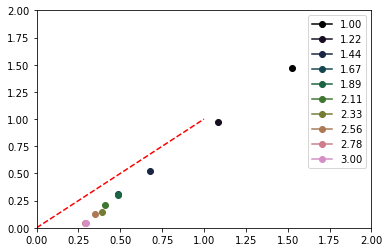

In [66]:
cmap = matplotlib.cm.get_cmap('cubehelix', )
norm = matplotlib.colors.Normalize(vmin=1, vmax=4)
for l in range(10):
    lam= np.linspace(1,3,10)[l]
    plt.plot(kls[l].detach(), mis[l].detach(),'-o', c=cmap(norm(lam)), label="{:.2f}".format(lam))
    plt.plot([0,1],[np.log(int(lam)*20),np.log(int(lam)*20)])
plt.xlim(0,2)
plt.ylim(0,2)
plt.plot([0,1],[0,1],'r--')
plt.legend()